In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import FastICA

def performICA(data, heartbeats_only=True):
    heartbeats = []
    ica = FastICA(n_components=4)
    data = data.T
    components = ica.fit_transform(data)
    for i in range(4):
        component = components[:, i]
        if np.min(component) < -2: component *= -1
        if np.max(component) > 4: heartbeats.append(component)
        if not heartbeats_only and np.max(component) <= 5: heartbeats.append(5)
    return heartbeats

In [3]:
file_range = range(153)
all_heartbeats = []
for i in file_range:
    filename = f'{i}'.zfill(3)
    data = loadmat(f'data/{filename}.mat')
    data_matrix = np.array(data['val'][0])
    heartbeats = performICA(data_matrix)
    for h in heartbeats:
        all_heartbeats.append((h, filename))

In [ ]:
!pip install heartpy

In [4]:
import heartpy as hp
from scipy.signal import find_peaks

def check_rotation(component, sr):
    distance = sr/10
    _, properties = find_peaks(component, distance=distance, height=0.1 * np.max(component))
    _ , inverted_properties = find_peaks(-component, distance=distance, height=0.1 * np.max(-component))

    # calculate average peak height for normal and inverted peaks to determine if signal is upside down or not
    avg_peak_height = np.mean(properties['peak_heights']) 
    avg_inv_peak_height = np.mean(inverted_properties['peak_heights']) 

    # flip signal if inverted peaks are taller
    if avg_inv_peak_height > avg_peak_height:
        component = -component

    return component

def calculate_heartrate(component, sr):
    component = check_rotation(component, sr)
    working_data, measures, heart_rate = None, None, None

    # Analyze the component signal with HeartPy
    working_data, measures = hp.process(component, sample_rate=sr)

    return component, working_data, measures

In [5]:
import warnings
warnings.simplefilter('ignore')

heartbeatsWithBpm = np.zeros(len(all_heartbeats), dtype=tuple)

for i, heartbeat in enumerate(all_heartbeats):
    try:
        component, working_data, measures = calculate_heartrate(heartbeat[0], 360)
        heartbeatsWithBpm[i] = (heartbeat[0], heartbeat[1], measures['bpm'], measures['pnn50'])
    except:
        heartbeatsWithBpm[i] = (None, None, None, None)
        continue

In [6]:
mother = []
fetus = []

fetusBpmMin = 110

for hb in heartbeatsWithBpm:
    if hb[2] == None: continue
    if hb[2] >= fetusBpmMin: fetus.append((hb[0], hb[1]))
    elif hb[2] < fetusBpmMin: mother.append((hb[0], hb[1]))

<h2> TODO </h2>
<ul>
<li>We have a list of tuples with shape (heartbeat_signal, file no. from which heartbeat originates, bpm, pnn50)</li>
    <ul>
        <li><b>Find a representative feature space which is indifferent to signal shift</b></li>
    </ul>
</ul>

In [7]:
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt

scaler = StandardScaler()
mother = np.array([[x[0][:1000], x[1]] for x in mother], dtype=object)
fetus = np.array([[x[0][:1000], x[1]] for x in fetus], dtype=object)


stdMother = scaler.fit_transform(list(mother[:,0]))
stdFetus = scaler.fit_transform(list(fetus[:,0]))

def butter_lowpass_filter(data, cutoff=20, fs=360, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

stdMotherFiltered = np.array([butter_lowpass_filter(x) for x in stdMother])
stdFetusFiltered = np.array([butter_lowpass_filter(x) for x in stdFetus])


In [8]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf')
clusterData_reduced = kpca.fit_transform(stdFetusFiltered)
print('Shape of reduced data ',clusterData_reduced.shape)

Shape of reduced data  (138, 2)


<h1>Clustering w/ DBSCAN</h1>

In [9]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=0.07, min_samples=2).fit(clusterData_reduced)
labels = dbs.labels_
n_clusters = len(set(labels))

print('# Cluster:', n_clusters)
print(labels)

# Cluster: 6
[ 0  0  1  0  0  0  0  2  0  0  0  0  0  0  0 -1  0 -1  0  3  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0
  0  4  0  0  0  0  0  0  2  0  3  0  0  0  0  0  0  0  0  0 -1  0  0  0
  3  0 -1  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0 -1  0 -1  0  3
  0  0 -1  0 -1 -1  4  0  0  0  0  0  2  0  1  0  0  0  0 -1  0  0  0  0
  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3]


14


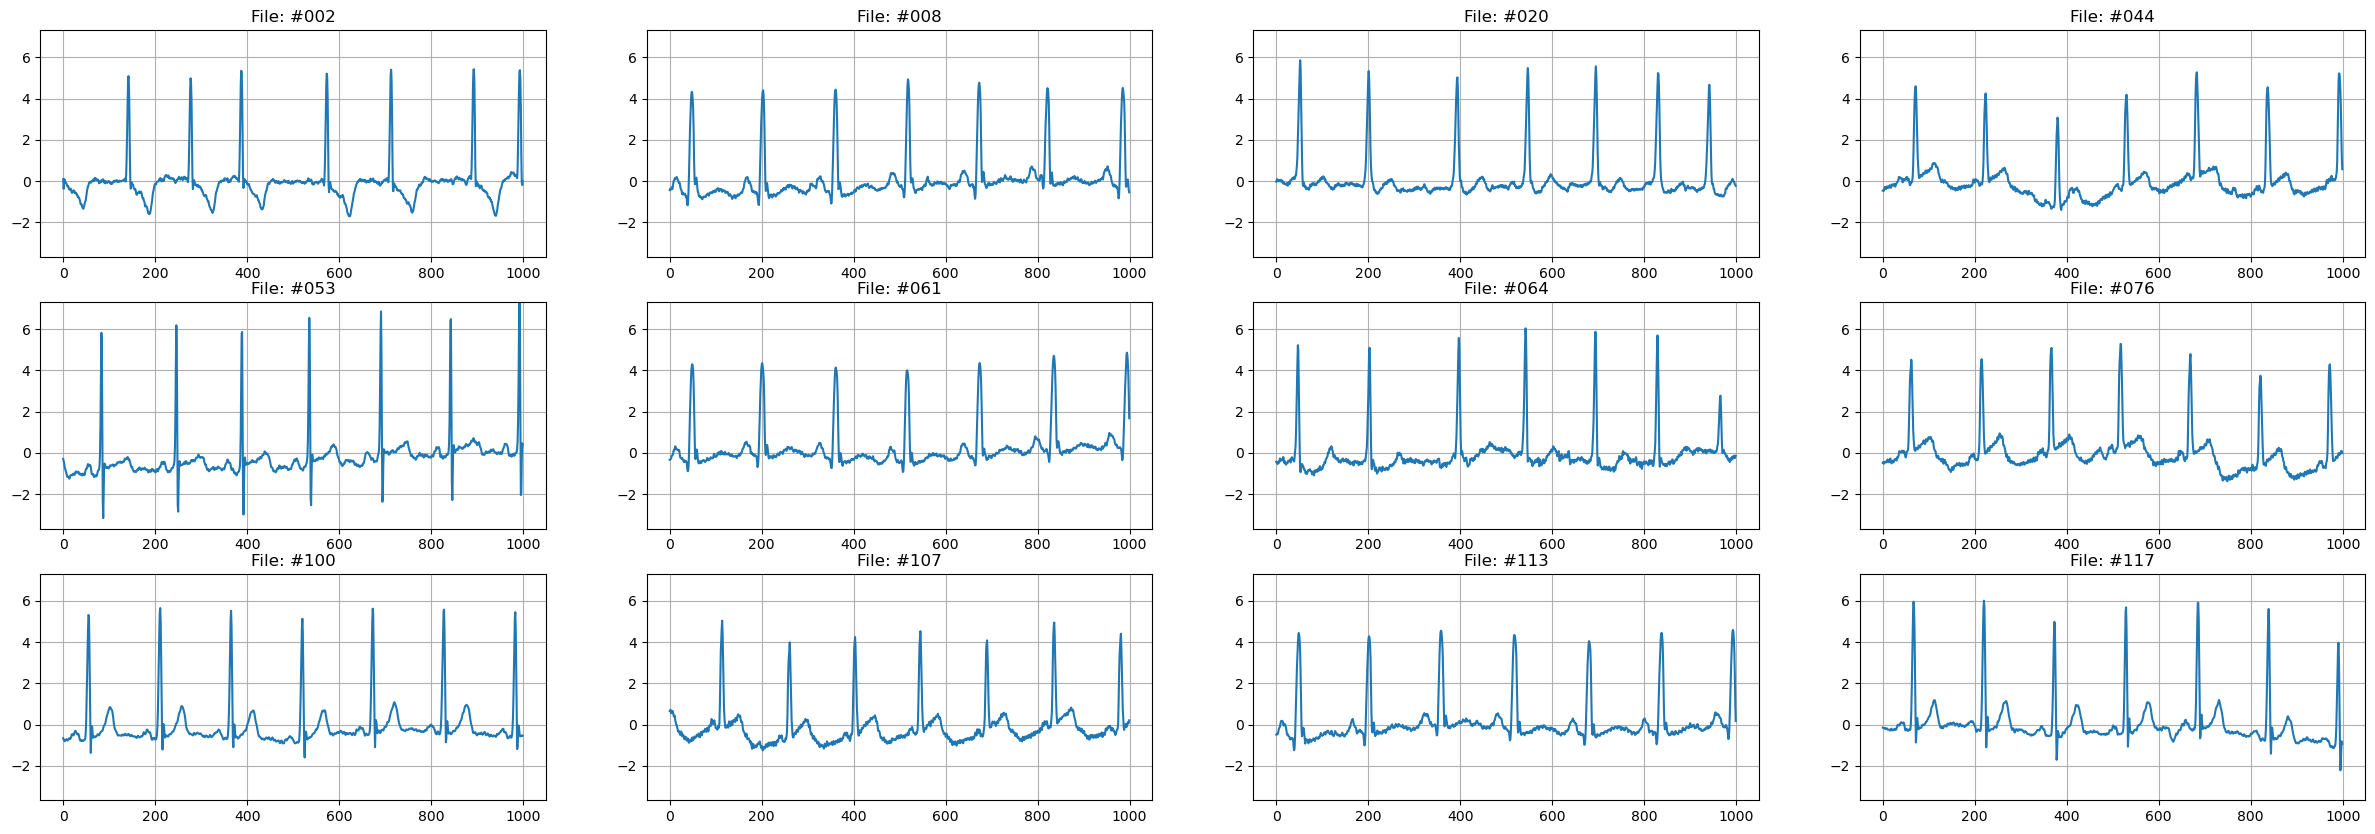

In [12]:
dbscan_anomalies = np.where((labels != -1) & (labels != 0))[0]
print(len(dbscan_anomalies))

plt.figure(figsize=(30, 10))

ymin, ymax = 0, 0
for i in range(len(dbscan_anomalies)):
    if np.min(fetus[:,0][i]) < ymin: ymin = np.min(fetus[:,0][i]) - .5
    if np.max(fetus[:,0][i]) > ymax: ymax = np.max(fetus[:,0][i]) + .5

for i, ind in enumerate(dbscan_anomalies[:12]):
    plt.subplot(3, 4, i+1)
    plt.plot(fetus[:,0][ind])
    plt.ylim(ymin, ymax)
    plt.title(f'File: #{fetus[:,1][ind]}')
    plt.grid()
plt.show()

***

<h1>GMMs</h1>

In [ ]:
from sklearn.decomposition import PCA
# Perform PCA keeping only the top 2 principal components
pca = PCA(n_components=2)
clusterData_reduced = pca.fit_transform(stdFetusFiltered)
print('Shape of reduced data ',clusterData_reduced.shape)

In [ ]:
from sklearn.mixture import GaussianMixture
# Fit the GMM
gmmData = clusterData_reduced
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(gmmData)
weights = gmm.weights_
print("Weights of each Gaussian component:", weights)
means = gmm.means_
print("Means of each Gaussian component:\n", means)
covariances = gmm.covariances_
print("Covariances of each Gaussian component:\n", covariances)

# Calculate the probability of each data point
scores = gmm.score_samples(gmmData)

# Set the threshold for anomalies
threshold = np.percentile(scores, 10)

# Identify anomalies
anomalies = gmmData[scores < threshold]
anomalies_idx = list(np.where(scores < threshold)[0])
anomalies_scores = scores[anomalies_idx]

print(f'# Anomalies: {len(anomalies)} {anomalies_idx}\n {anomalies_scores}')

plt.scatter(gmmData[:, 0], gmmData[:, 1], s=10, label='Data Points')
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', s=10, label='Anomalies')
plt.legend()
plt.title('Anomaly Detection using GMM')
plt.show()

In [ ]:
plt.plot(stdFetusFiltered[np.argmin(anomalies_scores)])
plt.grid()
plt.show()